[![Binder](https://mybinder.org/badge_logo.svg)](https://nbviewer.org/github/Sistemas-Multimedia/Sistemas-Multimedia.github.io/blob/master/milestones/10-ME/full_search_ME.ipynb)

# Full search block-based ME (Motion Estimation)
The predicted frame is divided into blocks and each one is characterized by a motion vector using exhaustive search. This guarantees reaching the global optimal (the best motion field).

In [1]:
import numpy as np
!ln -sf ~/MRVC/src/image_3.py .
import image_3 as frame
!ln -sf ~/MRVC/src/YCoCg.py .
import YCoCg as YUV
!ln -sf ~/MRVC/src/config.py .
!ln -sf ~/MRVC/src/debug.py .
!ln -sf ~/MRVC/src/motion.py .
import motion
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import cv2 as cv
plt.rcParams['text.usetex'] = True

OFCA: default number of levels = 3
OFCA: default window size = 33x33
OFCA: default number of iterations = 3
OFCA: extension mode = 1
OFCA: default poly_n 7
OFCA: default poly_sigma 1.5


In [29]:
def normalize(img):
    max_component = np.max(img)
    min_component = np.min(img)
    max_min_component = max_component - min_component
    return (img-min_component)/max_min_component

def show_frame(frame, prefix=None):
    #frame = normalize(frame)
    plt.figure(figsize=(10,10))
    plt.title(prefix, fontsize=10)
    plt.imshow(frame)

def show_vectors2(flow, dpi=150, downsampling=1):
    #plt.figure.set_dpi(200)
    plt.figure(dpi=dpi)
    plt.quiver(flow[..., 0][::downsampling], flow[..., 1][::downsampling])
    plt.show()
    
def show_vectors(flow, dpi=150, title=None):
    #plt.figure.set_dpi(200)
    plt.figure(dpi=dpi)
    plt.quiver(flow[..., 0][::-1], flow[..., 1])
    plt.title(title, fontsize=10)
    plt.show()

In [3]:
R = YUV.from_RGB(frame.read("/home/vruiz/MRVC/sequences/moving_circles/", 0).astype(np.int16))[...,0]
P = YUV.from_RGB(frame.read("/home/vruiz/MRVC/sequences/moving_circles/", 1).astype(np.int16))[...,0]

image_3.read: /home/vruiz/MRVC/sequences/moving_circles/000.png (64, 64, 3) uint8 684 
image_3.read: /home/vruiz/MRVC/sequences/moving_circles/001.png (64, 64, 3) uint8 684 


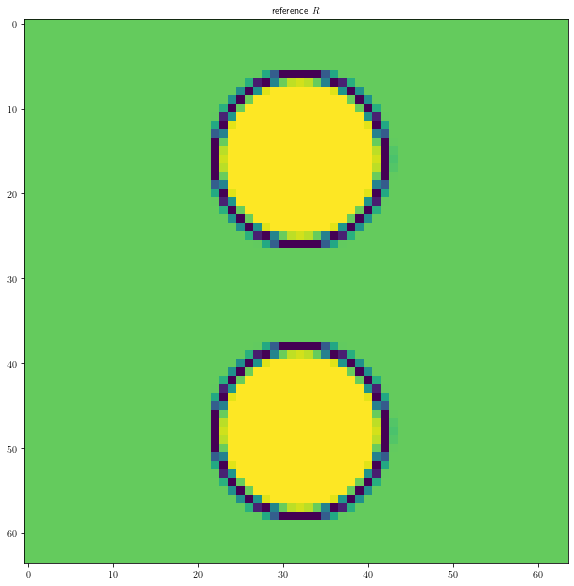

In [4]:
show_frame(R, "reference $R$")

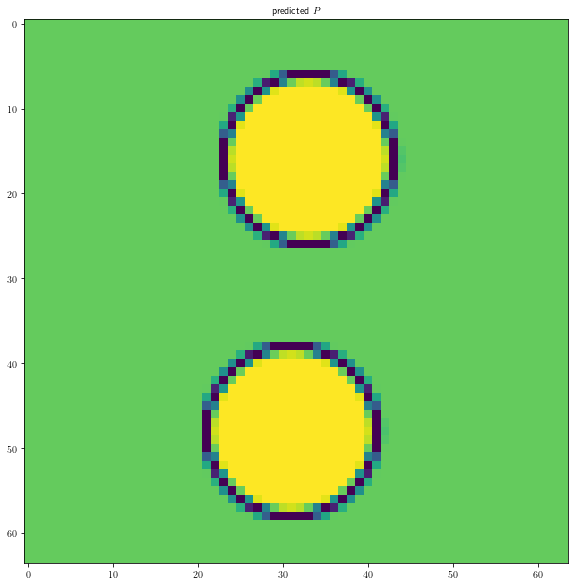

In [5]:
show_frame(P, "predicted $P$")

The top circle moves to the right and the bottom circle moves to the left. Therefore, if we want to generate the predicted frame (bottom) from the reference one (top), all the top MVs (Motion Vectors) related to the circle should be (x=1, y=0), and all the bottom MVs (-1, 0).

In [6]:
def full_search_block_based_ME_(P, R, block_side=16, max_abs_motion=8):
    assert max_abs_motion > 0
    extended_R = cv.copyMakeBorder(R, max_abs_motion, max_abs_motion, max_abs_motion, max_abs_motion, cv.BORDER_REPLICATE) 
    extended_R[max_abs_motion : R.shape[0] + max_abs_motion,
               max_abs_motion : R.shape[1] + max_abs_motion] = R
    show_frame(extended_R)
    motion = np.zeros((P.shape[0]//block_side, P.shape[1]//block_side, 2), dtype=np.int8)
    # All the coordinates are absolute (respect to P and R, that must have the same dimensions)
    for block_y_coor in range(0, P.shape[0], block_side):
        for block_x_coor in range(0, P.shape[1], block_side):
            errors_by_search_area = np.empty((block_side + max_abs_motion, block_side + max_abs_motion))
            counter = 0
            for search_range_y_coor in range(block_y_coor - max_abs_motion, block_y_coor + max_abs_motion):
                for search_range_x_coor in range(block_x_coor - max_abs_motion, block_x_coor + max_abs_motion):
                    #left_top_corner = [block_y_coor + search_range_y_coor, block_x_coor + search_range_x_coor]
                    #right_bottom_corner = [left_top_corner[0] + search_range, left_top_corner[1] + search_range]
                    R_block = extended_R[search_range_y_coor + max_abs_motion :
                                         search_range_y_coor + max_abs_motion + block_side,
                                         search_range_x_coor + max_abs_motion :
                                         search_range_x_coor + max_abs_motion + block_side]
                    P_block = P[block_y_coor :
                                block_y_coor + block_side,
                                block_x_coor :
                                block_x_coor + block_side]
                    print(search_range_y_coor+ max_abs_motion , search_range_y_coor + max_abs_motion  + block_side)
                    #print(block_side, R_block.shape, P_block.shape)
                    errors_in_search_area = np.abs(R_block - P_block)
                    show_frame(R_block, f"({search_range_y_coor + max_abs_motion}:{search_range_y_coor + max_abs_motion + block_side}, {search_range_x_coor + max_abs_motion}:{search_range_x_coor + max_abs_motion + block_side})")
                    show_frame(P_block)
                    show_frame(errors_in_search_area, f"{block_x_coor} {block_y_coor} x={search_range_x_coor} y={search_range_y_coor}")
                    error_by_block = np.sum(errors_in_search_area)
                    print((search_range_y_coor + max_abs_motion) % search_range)
                    errors_by_search_area[(search_range_y_coor + max_abs_motion) % search_range,
                                          (search_range_x_coor + max_abs_motion) % search_range] = error_by_block
                    #print(block_y_coor, block_x_coor, search_range_y_coor,
                    #      search_range_x_coor, R_block.shape, P_block.shape,
                    #      errors_in_search_area.shape, errors_in_search_area)
                    counter += 1
            mv_index = np.argmin(errors_by_search_area)
            MV_y = mv_index // search_range
            MV_x = mv_index % search_range
            flow[block_y_coor // block_side, block_x_coor // block_side] = (MV_x, MV_y)
            #print(mv_index, MV_y, MV_x, errors_by_search_area[MV_y, MV_x])
    return flow

def full_search_block_based_ME_(P, R, block_side=16, max_abs_motion=8):
    assert max_abs_motion > 0
    extended_R = cv.copyMakeBorder(R, max_abs_motion, max_abs_motion, max_abs_motion, max_abs_motion, cv.BORDER_REPLICATE) 
    extended_R[max_abs_motion : R.shape[0] + max_abs_motion,
               max_abs_motion : R.shape[1] + max_abs_motion] = R
    show_frame(extended_R, "extended R")
    blocks_in_y = P.shape[0]//block_side
    blocks_in_x = P.shape[1]//block_side
    MVs = np.zeros((blocks_in_y, blocks_in_x, 2), dtype=np.int8)
    for block_y_coor in range(blocks_in_y):
        for block_x_coor in range(blocks_in_x):
            errors_by_search_area = np.empty((block_side + 2*max_abs_motion, block_side + 2*max_abs_motion))
            for search_range_y_coor in range(2*max_abs_motion):
                for search_range_x_coor in range(2*max_abs_motion):
                    R_block = extended_R[block_y_coor*block_side + search_range_y_coor:
                                         (block_y_coor + 1)*block_side + search_range_y_coor,
                                         block_x_coor*block_side + search_range_x_coor:
                                         (block_x_coor + 1)*block_side + search_range_x_coor]
                    #print(block_y_coor, block_x_coor, search_range_y_coor, search_range_x_coor,
                    #      block_y_coor*block_side - search_range_y_coor + max_abs_motion,
                    #                     (block_y_coor + 1)*block_side - search_range_y_coor + max_abs_motion,
                    #                     block_x_coor*block_side - search_range_x_coor + max_abs_motion,
                    #                     (block_x_coor + 1)*block_side - search_range_x_coor + max_abs_motion)
                    P_block = P[block_y_coor*block_side :
                                (block_y_coor + 1)*block_side,
                                block_x_coor*block_side :
                                (block_x_coor + 1)*block_side]
                    #print(search_range_y_coor+ max_abs_motion , search_range_y_coor + max_abs_motion  + block_side)
                    #print(block_side, R_block.shape, P_block.shape)
                    errors_in_search_area = np.abs(R_block - P_block)
                    show_frame(R_block, f"R ({block_y_coor*block_side + search_range_y_coor}:{(block_y_coor + 1)*block_side + search_range_y_coor}, {block_x_coor*block_side + search_range_x_coor}:{(block_x_coor + 1)*block_side + search_range_x_coor})")
                    show_frame(P_block, f"P ({block_y_coor*block_side}:{(block_y_coor + 1)*block_side},{block_x_coor*block_side}:{(block_x_coor + 1)*block_side})")
                    show_frame(errors_in_search_area, f"{block_x_coor} {block_y_coor} x={search_range_x_coor} y={search_range_y_coor}")
                    error_by_block = np.sum(errors_in_search_area)
                    #print((search_range_y_coor + max_abs_motion) % search_range)
                    errors_by_search_area[block_y_coor, block_x_coor] = error_by_block
                    #print(block_y_coor, block_x_coor, search_range_y_coor,
                    #      search_range_x_coor, R_block.shape, P_block.shape,
                    #      errors_in_search_area.shape, errors_in_search_area)
            mv_index = np.argmin(errors_by_search_area)
            #MV_y = mv_index // 
            #MV_x = mv_index % search_range
            print(mv_index, errors_by_search_area.shape)
            #motion[block_y_coor, block_x_coor] = (MV_x, MV_y)
            #print(mv_index, MV_y, MV_x, errors_by_search_area[MV_y, MV_x])
    return MVs

def full_search_block_based_ME(P, R, block_side=16, max_abs_motion=8):
    
    def local_search(by, bx):
        errors_by_search_area = np.empty((2*max_abs_motion + 1, 2*max_abs_motion + 1))
        for ry in range(-max_abs_motion, max_abs_motion + 1):
            for rx in range(-max_abs_motion, max_abs_motion + 1):
                R_block = extended_R[by*block_side + ry + max_abs_motion:
                                    (by + 1)*block_side + ry + max_abs_motion,
                                    bx*block_side + rx + max_abs_motion:
                                    (bx + 1)*block_side + rx + max_abs_motion]
                #show_frame(R_block, f"R ({by} {bx} {ry} {rx} {by*block_side + ry + max_abs_motion}:{(by + 1)*block_side + ry + max_abs_motion}, {bx*block_side + rx + max_abs_motion}:{(bx + 1)*block_side + rx + max_abs_motion})")
                P_block = P[by*block_side : (by + 1)*block_side, bx*block_side : (bx + 1)*block_side]
                #show_frame(P_block, f"P ({by*block_side}:{(by + 1)*block_side},{bx*block_side}:{(bx + 1)*block_side})")
                #errors_in_search_area = np.abs(R_block - P_block)
                #error_by_block = np.sum(errors_in_search_area)
                error = R_block.astype(np.float32) - P_block
                errors_in_search_area = error*error
                error_by_block = np.average(errors_in_search_area)
                #show_frame(errors_in_search_area, f"by={by} bx={bx} ry={ry} rx={rx} error={error_by_block}")
                errors_by_search_area[ry + max_abs_motion, rx + max_abs_motion] = error_by_block
                #show_frame(errors_by_search_area, "errors")
        mv_index = np.argmin(errors_by_search_area)
        if errors_by_search_area[max_abs_motion, max_abs_motion] == errors_by_search_area[0, 0]:
            MV_y, MV_x = 0, 0
        else:
            MV_y = mv_index // (2*max_abs_motion + 1) - max_abs_motion
            MV_x = mv_index  % (2*max_abs_motion + 1) - max_abs_motion
        #print("index=", mv_index, "y=", MV_y, "x=", MV_x)
        #print(errors_by_search_area.astype(np.int))
        return MV_y, MV_x

    assert max_abs_motion > 0
    extended_R = cv.copyMakeBorder(R, max_abs_motion, max_abs_motion, max_abs_motion, max_abs_motion, cv.BORDER_REPLICATE) 
    extended_R[max_abs_motion : R.shape[0] + max_abs_motion,
               max_abs_motion : R.shape[1] + max_abs_motion] = R
    #show_frame(extended_R, "extended R")
    blocks_in_y = P.shape[0]//block_side
    blocks_in_x = P.shape[1]//block_side
    MVs = np.zeros((blocks_in_y, blocks_in_x, 2), dtype=np.int8)
    #print(blocks_in_y, blocks_in_x)
    for by in range(blocks_in_y):
        for bx in range(blocks_in_x):
            MV_y, MV_x = local_search(by, bx)
            MVs[by, bx] = (MV_x, MV_y)
    return MVs

block_side = 32
max_abs_motion = 1
MVs = full_search_block_based_ME(P, R, block_side=block_side, max_abs_motion=max_abs_motion)

In [7]:
MVs.shape

(2, 2, 2)

In [8]:
for y in range(P.shape[0]//block_side):
    for x in range(P.shape[1]//block_side):
        print(MVs[y, x], end=' ')
    print()

[-1  0] [-1  0] 
[1 0] [1 0] 


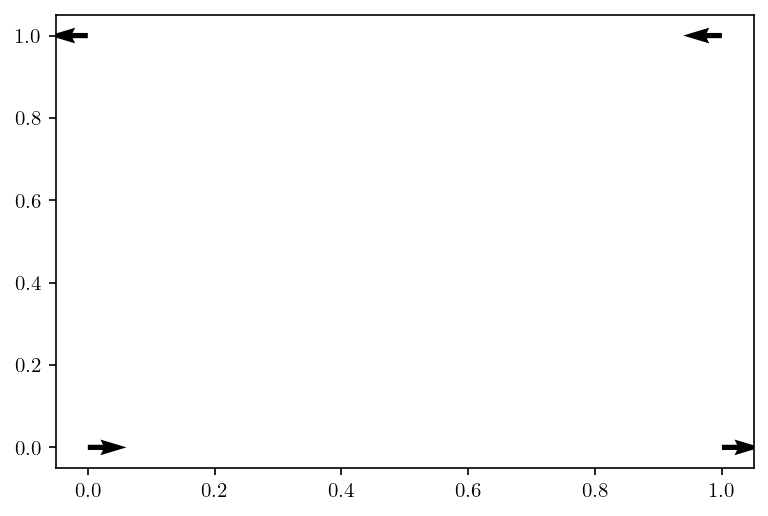

In [9]:
show_vectors(MVs[::1, ::1])

## Interpolate the MVs
The predictor expects a dense motion field.

In [10]:
from scipy import ndimage
_MVs = np.empty((P.shape[0], P.shape[1], 2), dtype=np.float32)
print(_MVs.shape)
_MVs[..., 0] = ndimage.zoom(MVs[..., 0], P.shape[0]/MVs.shape[0], order=0)
_MVs[..., 1] = ndimage.zoom(MVs[..., 1], P.shape[0]/MVs.shape[0], order=0)

(64, 64, 2)


## Make the prediction

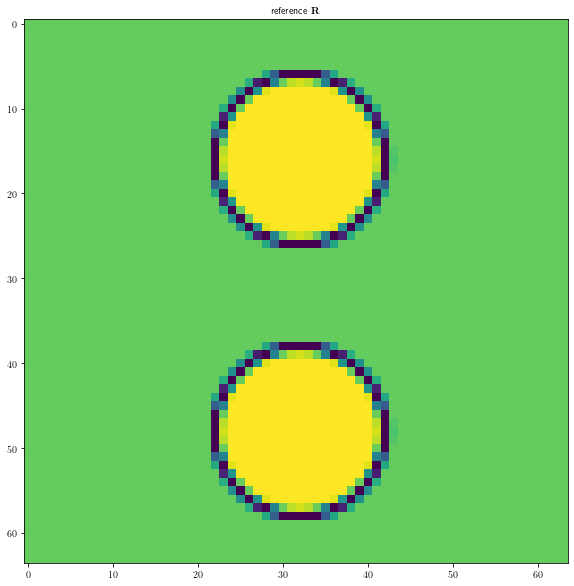

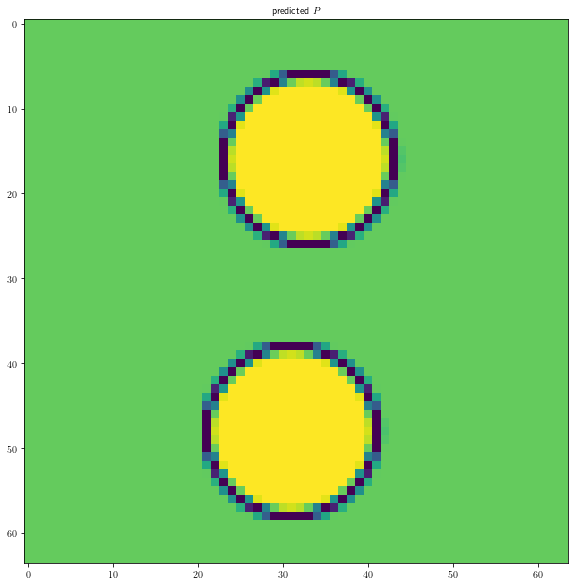

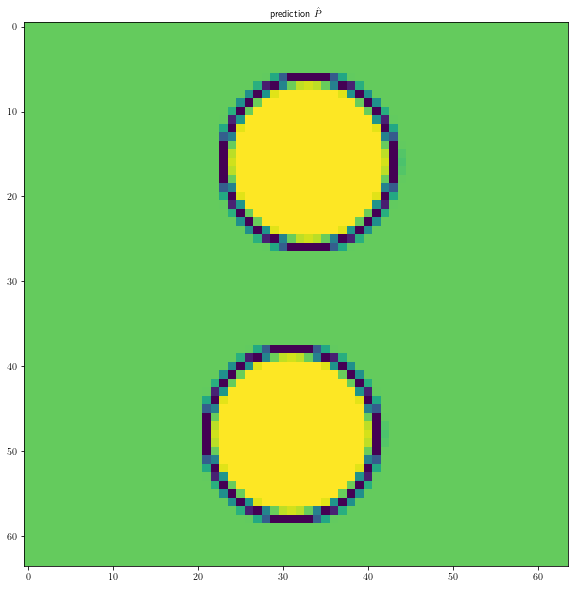

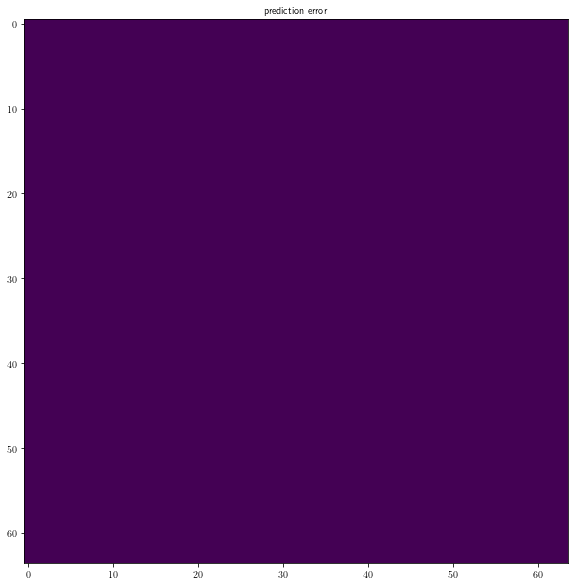

In [11]:
hat_P = motion.make_prediction(R, _MVs)
show_frame(R, "reference ${\mathbf R}$")
show_frame(P, "predicted $P$")
show_frame(hat_P, "prediction $\hat{P}$")
show_frame(P-hat_P, "prediction error")

## More distance

In [12]:
R = YUV.from_RGB(frame.read("/home/vruiz/MRVC/sequences/moving_circles/", 0).astype(np.int16))[...,0]
P = YUV.from_RGB(frame.read("/home/vruiz/MRVC/sequences/moving_circles/", 2).astype(np.int16))[...,0]

image_3.read: /home/vruiz/MRVC/sequences/moving_circles/000.png (64, 64, 3) uint8 684 
image_3.read: /home/vruiz/MRVC/sequences/moving_circles/002.png (64, 64, 3) uint8 684 


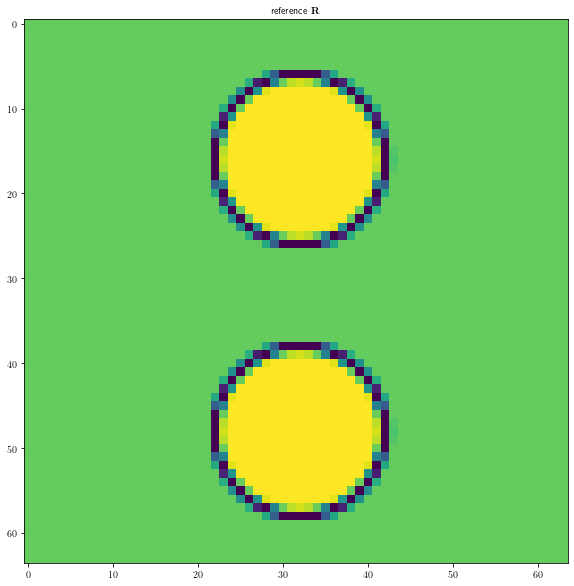

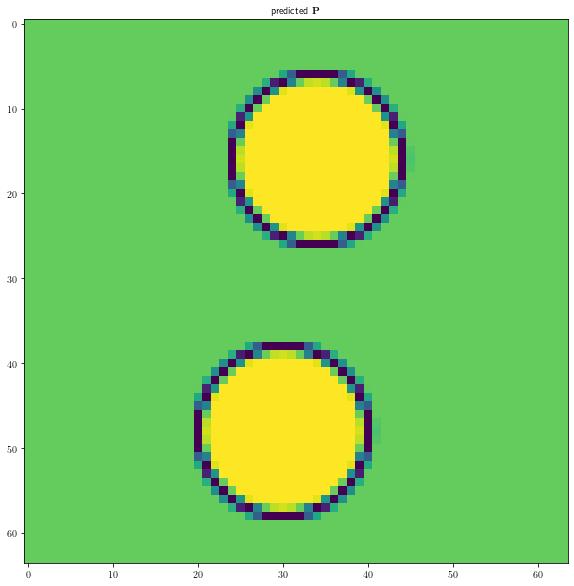

In [13]:
show_frame(R, "reference ${\mathbf R}$")
show_frame(P, "predicted ${\mathbf P}$")

In [14]:
block_side = 16
max_abs_motion = 4
MVs = full_search_block_based_ME(P, R, block_side=block_side, max_abs_motion=max_abs_motion)

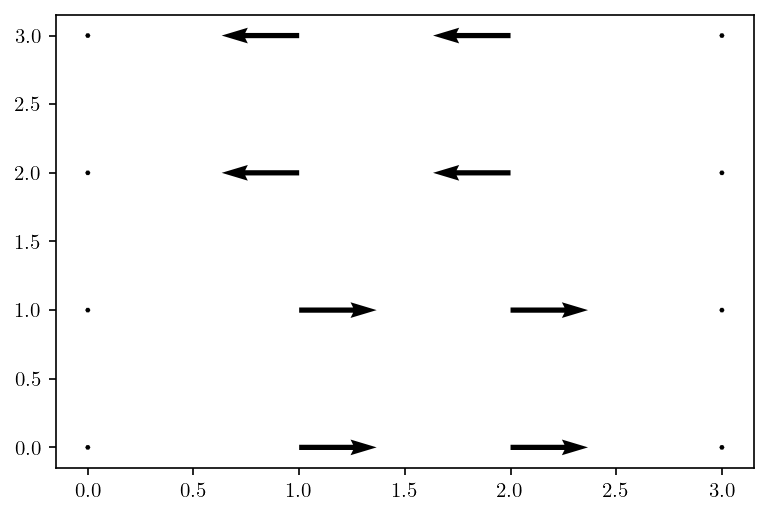

In [15]:
show_vectors(MVs[::1, ::1])

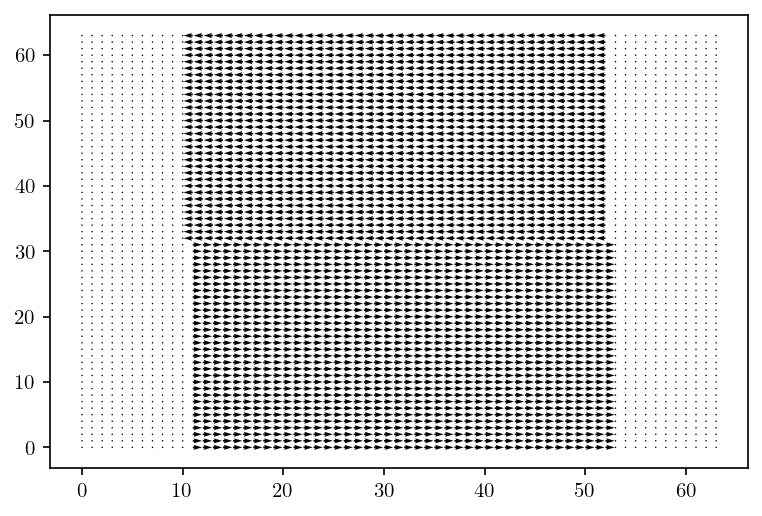

In [16]:
from scipy import ndimage
_MVs = np.empty((P.shape[0], P.shape[1], 2), dtype=np.float32)
_MVs[..., 0] = ndimage.zoom(MVs[..., 0], P.shape[0]/MVs.shape[0], order=0)
_MVs[..., 1] = ndimage.zoom(MVs[..., 1], P.shape[0]/MVs.shape[0], order=0)
show_vectors(_MVs[::1, ::1])

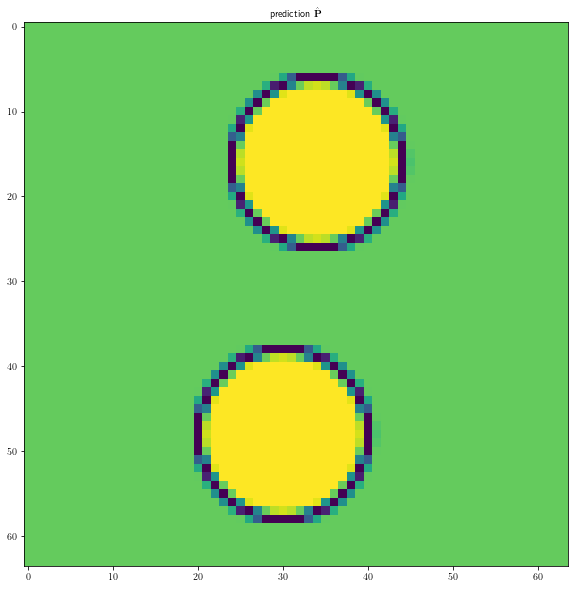

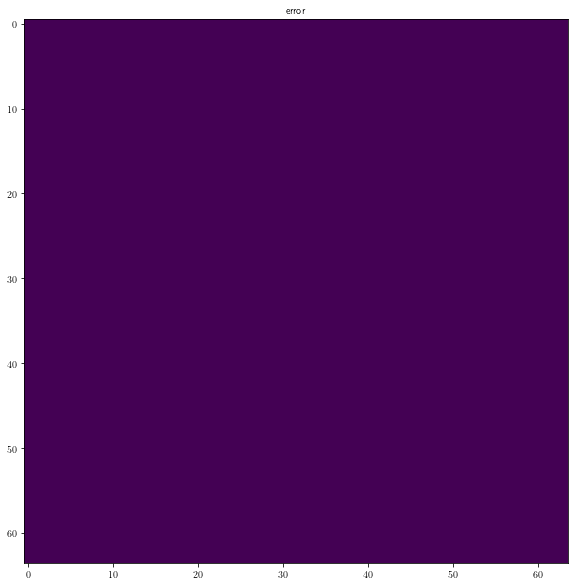

In [17]:
hat_P = motion.make_prediction(R, _MVs)
show_frame(hat_P, "prediction $\hat{\mathbf P}$")
show_frame(P-hat_P, "error")

## Even more distance

In [18]:
R = YUV.from_RGB(frame.read("/home/vruiz/MRVC/sequences/moving_circles/", 0).astype(np.int16))[...,0]
P = YUV.from_RGB(frame.read("/home/vruiz/MRVC/sequences/moving_circles/", 4).astype(np.int16))[...,0]

image_3.read: /home/vruiz/MRVC/sequences/moving_circles/000.png (64, 64, 3) uint8 684 
image_3.read: /home/vruiz/MRVC/sequences/moving_circles/004.png (64, 64, 3) uint8 684 


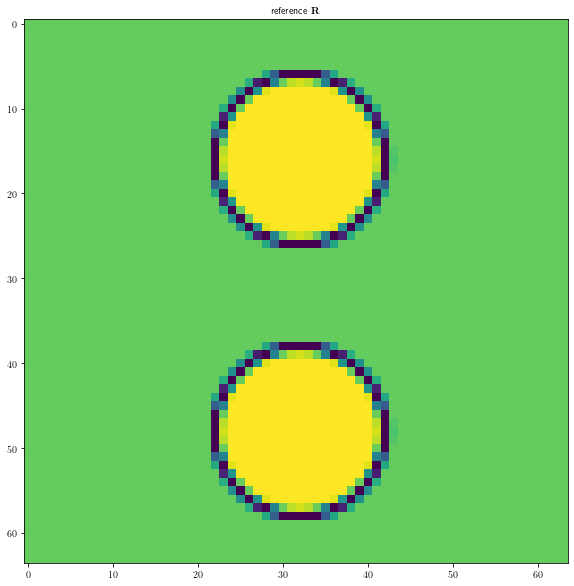

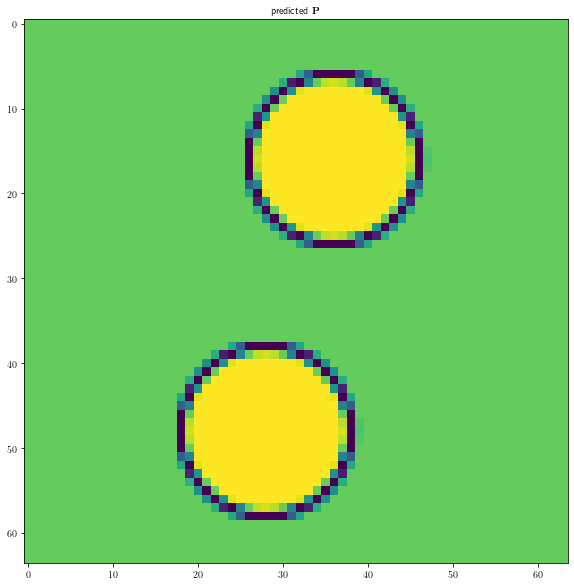

In [19]:
show_frame(R, "reference ${\mathbf R}$")
show_frame(P, "predicted ${\mathbf P}$")

In [20]:
block_side = 16
max_abs_motion = 8
MVs = full_search_block_based_ME(P, R, block_side=block_side, max_abs_motion=max_abs_motion)

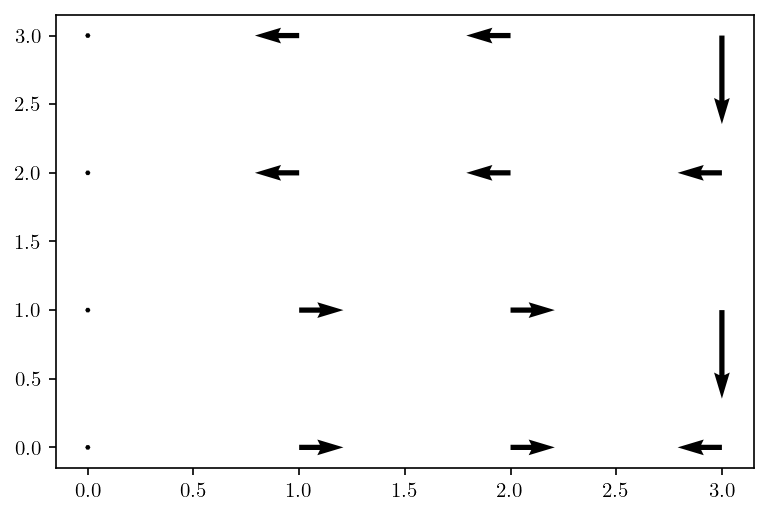

In [21]:
show_vectors(MVs[::1, ::1])

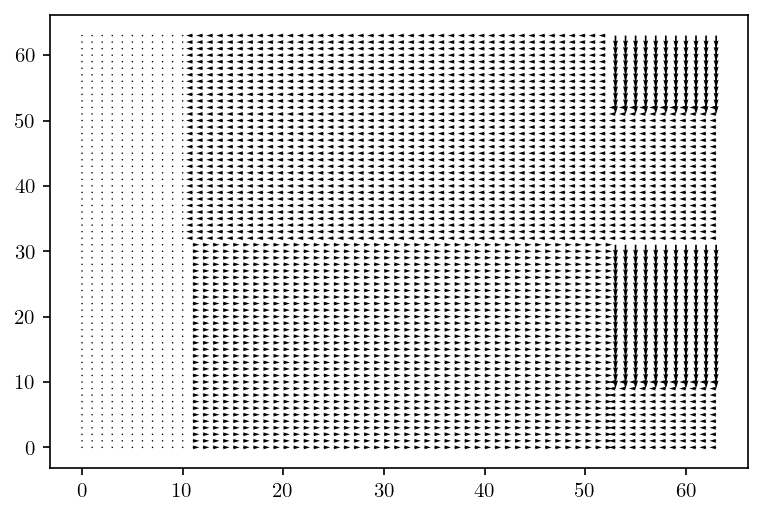

In [22]:
from scipy import ndimage
_MVs = np.empty((P.shape[0], P.shape[1], 2), dtype=np.float32)
_MVs[..., 0] = ndimage.zoom(MVs[..., 0], P.shape[0]/MVs.shape[0], order=0)
_MVs[..., 1] = ndimage.zoom(MVs[..., 1], P.shape[0]/MVs.shape[0], order=0)
show_vectors(_MVs[::1, ::1])

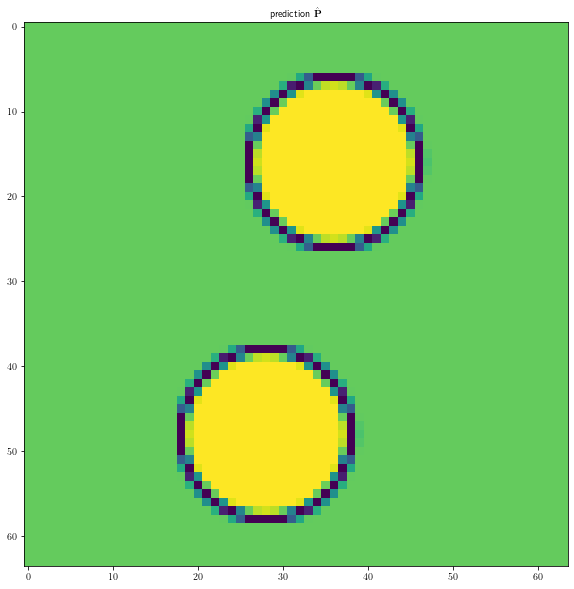

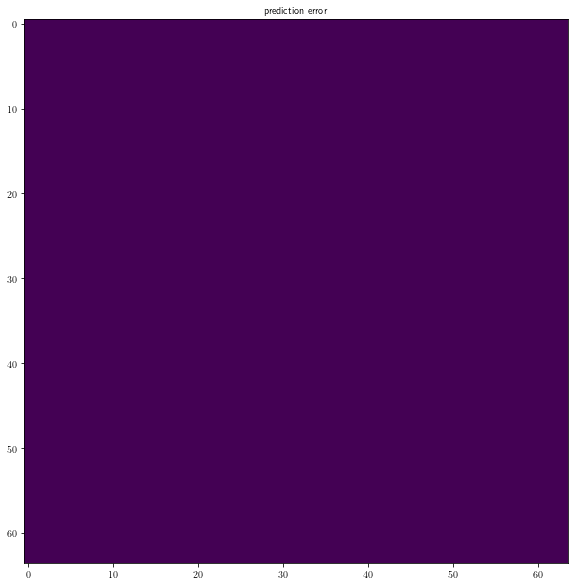

In [23]:
hat_P = motion.make_prediction(R, _MVs)
show_frame(hat_P, "prediction $\hat{\mathbf P}$")
show_frame(P-hat_P, "prediction error")

## Now with a real image

image_3.read: /home/vruiz/MRVC/sequences/stockholm/000.png (768, 1280, 3) uint8 1927590 
image_3.read: /home/vruiz/MRVC/sequences/stockholm/001.png (768, 1280, 3) uint8 1927644 


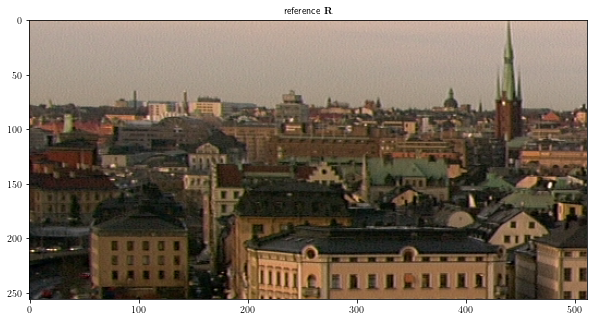

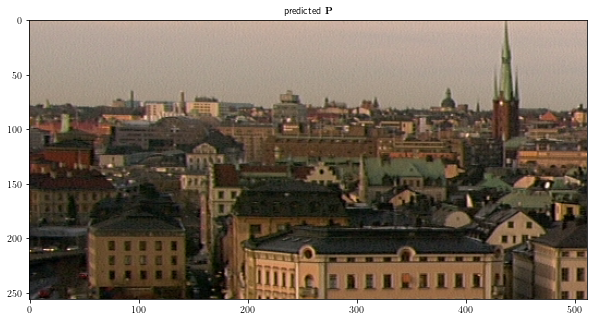

In [31]:
prefix = "/home/vruiz/MRVC/sequences/stockholm/"
R = frame.read(prefix, 0)[100:356,100:612]
P = frame.read(prefix, 1)[100:356,100:612]
show_frame(R, "reference ${\mathbf R}$")
show_frame(P, "predicted ${\mathbf P}$")

In [32]:
block_side = 16
max_abs_motion = 8
MVs = full_search_block_based_ME(P, R, block_side=block_side, max_abs_motion=max_abs_motion)

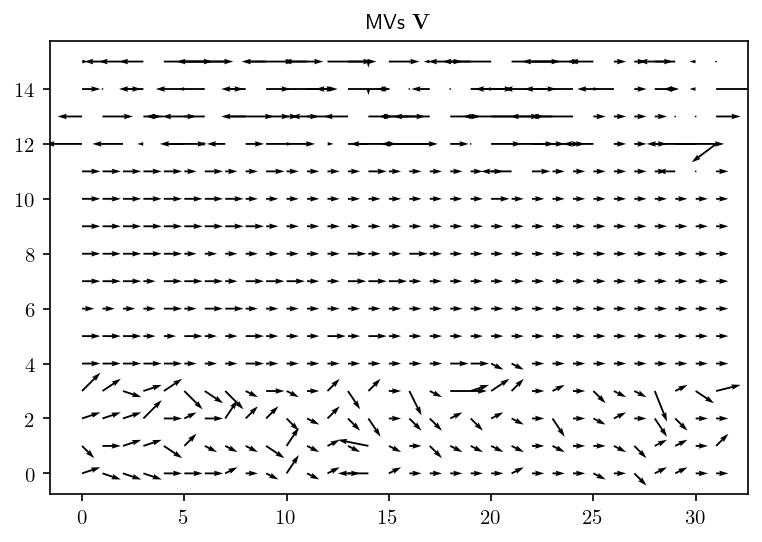

In [34]:
show_vectors(MVs[::1, ::1], title="MVs ${\mathbf V}$")

In [27]:
from scipy import ndimage
_MVs = np.empty((P.shape[0], P.shape[1], 2), dtype=np.float32)
print(_MVs.shape)
_MVs[..., 0] = ndimage.zoom(MVs[..., 0], P.shape[0]/MVs.shape[0], order=0)
_MVs[..., 1] = ndimage.zoom(MVs[..., 1], P.shape[0]/MVs.shape[0], order=0)

(256, 512, 2)


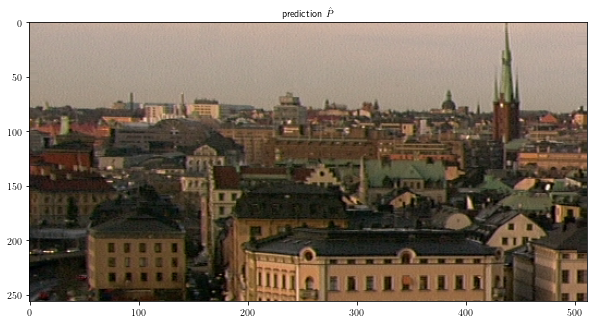

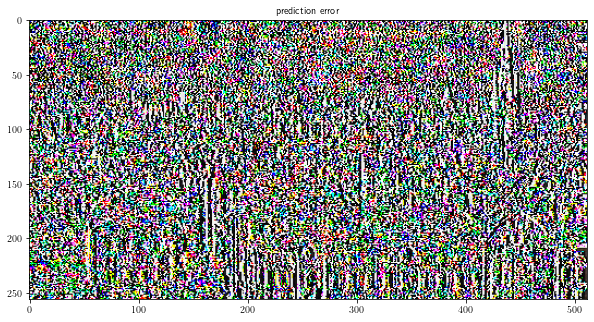

In [28]:
hat_P = motion.make_prediction(R, _MVs)
show_frame(hat_P, "prediction $\hat{P}$")
show_frame(P - hat_P, "prediction error")